# Summary - Gather Process Trees

### Part I

1. From the ```process_uber_summary``` table, build an ```igraph``` directed graph $G$ where each edge is of the form: ```parent PID --> child PID```
2. Enrich $G$ with metadata for each PID (process name, timestamp, mitre labels, etc.)
3. Get all (weak) connected components from $G$ -- those are the ```process trees``` (with one exception where a loop is present), and save those in the **Trees** object
4. Provide some basic visualization and EDA for the process trees

### Part II

Most process trees are of size 2, and a few are huge.
For every process tree of size 3 to 10,0000, consider every rooted subtree of size 3 or more that has a process name for the root and gather the following statistics:

1. The tree and root node indices in the **Trees** object
2. Number of nodes, leaves, tree depth, number of nodes at each level, list of process names at each level
3. Number of splits (forks of size 2 or more) and ratio of splits to nodes (this can be used to filter broom-like trees, for example)
4. Number of processes from a *baduser*
5. Save the above in dataframe **process_df**

### Part III

Two validation experiments using the subtrees in **process_df**: clustering and nearest neighbours.

### Part IV

Using the Acme4 process tree data saved in the **Trees** and **process_df** objects, generate some illustrative plots using Algorithm 1 (Basic Matching Algorithm) from: "Finding Meaningful Paths in Trees" (M. Le, P. Pralat, A. Smith and F. Theberge), in preparation.
This algorithm finds matching paths in trees using node labels.


# Introduction

The first few cells are taken from BH's ```process-name-curation``` notebook


In [1]:
%load_ext autoreload
%load_ext dotenv
#%load_ext quak 
%load_ext sql

Tip: You may define configurations in /work/home/fcthebe/Acme4/Forked/Wintap-Analytics/2025-acme4-explore/pyproject.toml or /work/home/fcthebe/.jupysql/config.

Did not find user configurations in /work/home/fcthebe/Acme4/Forked/Wintap-Analytics/2025-acme4-explore/pyproject.toml.

In [2]:
%autoreload 1
%aimport acme4_explore

In [3]:
%dotenv

cannot find .env file


In [4]:
%%time
import acme4_explore
import datamapplot as dmp
from fast_hdbscan import HDBSCAN
import io
import json
import logging as lg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sentencepiece import SentencePieceTrainer, SentencePieceProcessor
from sklearn.metrics.pairwise import paired_distances
from tqdm.auto import tqdm, trange
import umap
import vectorizers as vz
import vectorizers.transformers as vzt
import zstandard as zstd

import seaborn as sns
from collections import Counter
import igraph as ig


CPU times: user 30.4 s, sys: 1.83 s, total: 32.3 s
Wall time: 26.7 s


In [5]:
# Registers the current `tqdm` class with pandas.core.
tqdm.pandas()


In [6]:
lg.basicConfig(**acme4_explore.logging_config())
LOG = lg.getLogger("notebook")


In [7]:
db = acme4_explore.connect_db()
%sql db --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True


# Part I --  Build process trees from the ```process_uber_summary``` table

We keep a subset of the columns to build the process trees plus some extra information for each process.


In [8]:
%%sql process_summary <<
select * from process_uber_summary


In [9]:
cols = ['pid_hash', 
        'parent_pid_hash',
        'process_name',
        'process_path',
        'user_name',
        'mitre_analytic_ids',
        'lolbas_mitre',
        'total_sigma_hits',
        'process_started'
        
]
df = process_summary[cols]    
df = df.drop_duplicates([
        'pid_hash', 
        'parent_pid_hash',
        'process_name',
        'process_path',
        'user_name',
        'total_sigma_hits',
        'process_started'])
print('shape:',df.shape)
df.head(5)


shape: (1772947, 9)


,pid_hash,parent_pid_hash,process_name,process_path,user_name,mitre_analytic_ids,lolbas_mitre,total_sigma_hits,process_started
0,55EB90CA560661116B2960AB86A5B0C2,6DA116CF30116D13D73F0176C88FE8FA,wmic.exe,c:\windows\system32\wbem\wmic.exe,None,[CAR-2021-05-012],"[T1218, T1564.004]",2.0,2024-09-21 08:46:37.950828+00:00
1,1C0E33336B247AB3545467D0C90A801C,7BAAE96741807787EFD2D6522B8C6B04,wmic.exe,c:\windows\system32\wbem\wmic.exe,None,[CAR-2021-05-012],"[T1218, T1564.004]",2.0,2024-09-21 13:54:18.404907+00:00
2,3657145DA95C462B0F632F0A93E632E3,6FB634509A57999E72BCAFA74A8FFF29,wmic.exe,c:\windows\system32\wbem\wmic.exe,None,[CAR-2021-05-012],"[T1218, T1564.004]",3.0,2024-09-21 18:31:49.308847+00:00
3,DB85B49E03DF8060FA14B3F0B934D589,7BAAE96741807787EFD2D6522B8C6B04,wmic.exe,c:\windows\system32\wbem\wmic.exe,None,[CAR-2021-05-012],"[T1218, T1564.004]",2.0,2024-09-21 15:49:18.430852+00:00
4,2D9432D76FDFDEF205D46F0137EAFEB3,7BAAE96741807787EFD2D6522B8C6B04,wmic.exe,c:\windows\system32\wbem\wmic.exe,None,[CAR-2021-05-012],"[T1218, T1564.004]",3.0,2024-09-21 17:49:18.352182+00:00


## Build graph $G$ and find the connected components 

* directed edges are set to : parent -> child
* the connected components correspond to the process trees (with one exception which has a loop)
* main objects: ```G``` is the overall directed graph and ```Trees``` contains all process trees


### Build graph $G$

In [10]:
child = set(df.pid_hash)
parent = set(df.parent_pid_hash)
print('processes:')
print('children:',len(child),', parents:',len(parent),', both:',len(parent.intersection(child)))

## node dictionaries
nodes = parent.union(child)
nodes_dict = {v:k for k,v in enumerate(nodes)}
inv_nodes_dict = {k:v for k,v in enumerate(nodes)}

## build directed graph from edgelist
child = [nodes_dict[x] for x in df.pid_hash]
parent = [nodes_dict[x] for x in df.parent_pid_hash]
edges = np.array([parent,child]).T

## build graph
G = ig.Graph.TupleList(edges, directed=True)
G = G.simplify() ## there are 53 self-edges
print('final tree:')
print('nodes:',G.vcount(),', edges:',G.ecount())
G.vs['pid'] = [inv_nodes_dict[int(x)] for x in G.vs['name']]


processes:
children: 1772947 , parents: 1253672 , both: 142448
final tree:
nodes: 2884171 , edges: 1772894


### Save components in **Trees** object


In [11]:
## find all connected components a.k.a. process trees (with one exception)
Trees = G.connected_components(mode="weak")
G.vs['tree'] = Trees.membership
print('Number of components:',len(Trees))
## most common component sizes
print('most common sizes:')
Counter([len(x) for x in Trees]).most_common(5)


Number of components: 1111278
most common sizes:


[(2, 1111052), (3, 94), (4, 21), (5, 12), (12, 11)]

In [12]:
## largest tree
np.max([len(x) for x in Trees])


np.int64(257744)

### Example

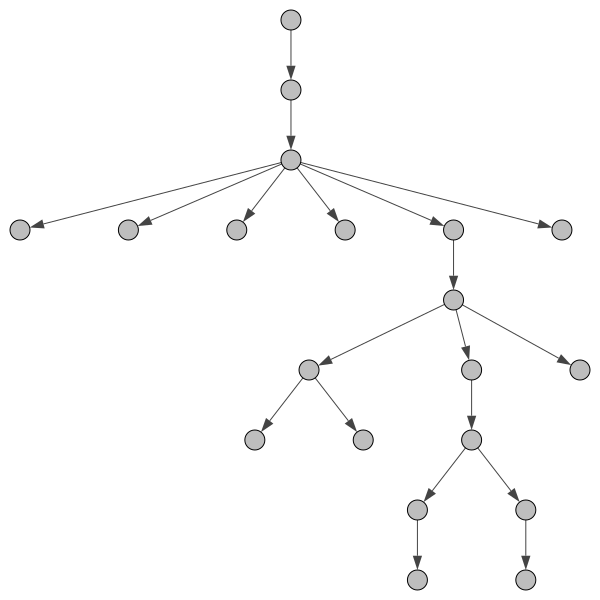

In [13]:
## ex: showing a size 20 component
idx = np.where(np.array(Trees.sizes())==20)[0][0]
sg = Trees.subgraph(idx)
ly = sg.layout_reingold_tilford()
#ig.plot(sg, 'smalltree_1.png', layout=ly, vertex_color='grey', vertex_label_size=0)
ig.plot(sg, layout=ly, vertex_color='grey', vertex_label_size=0)


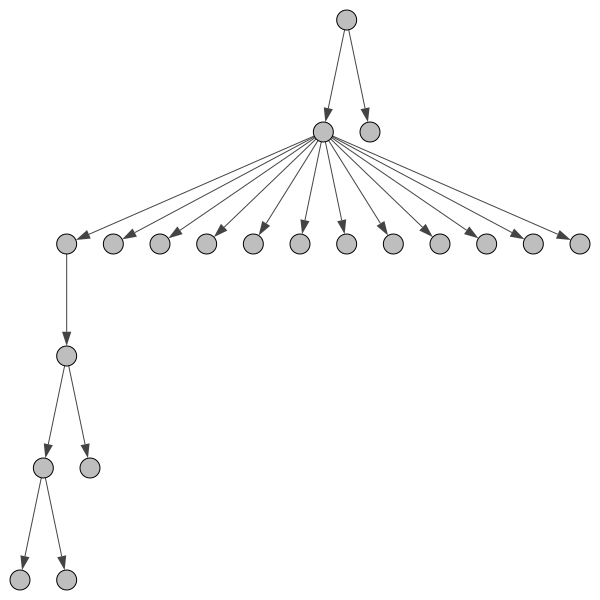

In [14]:
## ex: showing another size 20 component
idx = np.where(np.array(Trees.sizes())==20)[0][1]
sg = Trees.subgraph(idx)
ly = sg.layout_reingold_tilford()
#ig.plot(sg, 'smalltree_2.png', layout=ly, vertex_color='grey', vertex_label_size=0)
ig.plot(sg, layout=ly, vertex_color='grey', vertex_label_size=0)


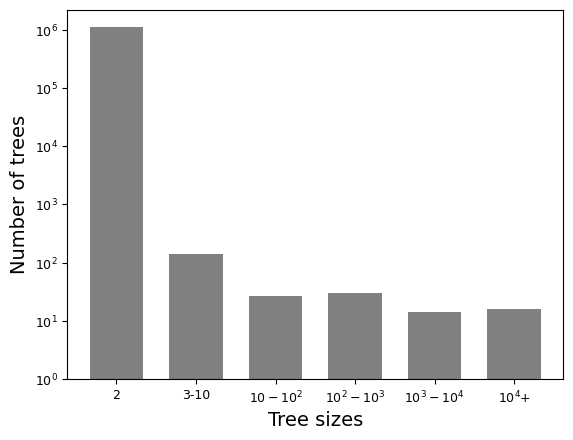

In [15]:
## Number of trees w.r.t. tree sizes
X = [len(x) for x in Trees]
bins = [2,3,10,100,1000,10000,1000000]
counts,_ = np.histogram(X,bins)
plt.bar([0,1,2,3,4,5],np.log10(counts),width=.67, color='grey')
plt.xticks([0,1,2,3,4,5],['2','3-10',r'$10-10^2$',r'$10^2-10^3$',r'$10^3-10^4$',r'$10^4$+'], rotation=0, fontsize=9);
plt.yticks([0,1,2,3,4,5,6],[r'$10^0$',r'$10^1$',r'$10^2$',r'$10^3$',r'$10^4$',r'$10^5$',r'$10^6$'], rotation=0, fontsize=9);
plt.ylabel('Number of trees',fontsize=14)
plt.xlabel('Tree sizes',fontsize=14);
#plt.savefig('treesizes.png');


### There are 1,111,278 components -- one component is NOT a tree


In [16]:
## count roots (having in-degree zero)
print('number of roots:',sum(np.array(G.degree(mode='in'))==0))

## identify the non-tree component
s = set(np.array(Trees.membership)[np.where(np.array(G.degree(mode='in'))==0)[0]])
c = set(np.arange(1111278)).difference(s)
non_tree = c.pop()
sg = Trees.subgraph(non_tree)
print('\nnon-tree:\n','nodes:',sg.vcount(),'edges:',sg.ecount())
print(' acyclic:',sg.is_acyclic())
print(' index in Trees object:',non_tree)


number of roots: 1111277

non-tree:
 nodes: 22576 edges: 22576
 acyclic: False
 index in Trees object: 731680


### Adding node features

Enrich graph ```G``` with:

* username
* process name
* timestamp
* mitre and lolbas ids, sigma count

and look at the most common values.


In [17]:
## usernames
user_dict = dict(zip(df.pid_hash,df.user_name))
G.vs['username'] = [user_dict.get(x, None) for x in G.vs['pid']]
Counter(G.vs['username']).most_common(10)


[(None, 2582643),
 ('NT AUTHORITY\\SYSTEM', 282540),
 ('ACME\\ghostuser2', 3956),
 ('NT AUTHORITY\\NETWORK SERVICE', 3621),
 ('ACME\\grantj', 2165),
 ('ACME\\ghostuser1', 1364),
 ('ACME\\user10', 1198),
 ('ACME\\user1', 1143),
 ('ACME\\davidf', 803),
 ('ACME\\user3', 747)]

In [18]:
## process names
process_dict = dict(zip(df.pid_hash, df.process_name))
G.vs['process'] = [process_dict.get(x, "") for x in G.vs['pid']]
# merge None and ''
x = np.where(np.array(G.vs['process'])==None)[0]
G.vs[x]['process'] = ''
Counter(G.vs['process']).most_common(10)


[('conhost.exe', 1243884),
 ('', 1118246),
 ('wmic.exe', 283125),
 ('mergehelper.exe', 122882),
 ('svchost.exe', 14979),
 ('updater.exe', 9939),
 ('taskhostw.exe', 8159),
 ('microsoftedgeupdate.exe', 7889),
 ('mousocoreworker.exe', 7219),
 ('firefox.exe', 6911)]

In [19]:
## timestamps
T = []
for x in df['process_started']:
    if pd.isna(x):
        T.append('')
    else: 
        T.append(int(x.timestamp()))
time_dict = dict(zip(df.pid_hash, T))
G.vs['time'] = [time_dict.get(x, "") for x in G.vs['pid']]


In [20]:
## mitre, lolbas, sigma
_dict = dict(zip(df.pid_hash, df.mitre_analytic_ids))
G.vs['mitre'] = [_dict.get(x, "") for x in G.vs['pid']]
_dict = dict(zip(df.pid_hash, df.lolbas_mitre))
G.vs['lolbas'] = [_dict.get(x, "") for x in G.vs['pid']]
_dict = dict(zip(df.pid_hash, df.total_sigma_hits))
G.vs['sigma'] = [_dict.get(x, "") for x in G.vs['pid']]


### Plotting parameters

* We set short pseudo usernames and select node colours for plotting
* For node labels, we use: short_username::process_name
* note that username and/or process_name may be blank


In [21]:
## short names for plotting and anonymize
shortname_dict = {'ACME-HH-BKQ\\ssm-user':'ssmBKQ',
 'ACME-HH-WHS\\ssm-user':'ssmWHS',
 'ACME-HH-YVU\\ssm-user':'ssmYVU',
 'ACME-WS-PLU\\ssm-user':'ssmPLU',
 'ACME\\SUPERDA':'user99',
 'ACME\\baduser25':'bad25',
 'ACME\\baduser3':'bad3',
 'ACME\\baduser9':'bad9',
 'ACME\\davidf':'user77',
 'ACME\\ghostuser1':'ghost1',
 'ACME\\ghostuser2':'ghost2',
 'ACME\\grantj':'user88',
 'ACME\\user1':'user1',
 'ACME\\user10':'user10',
 'ACME\\user11':'user11',
 'ACME\\user2':'user2',
 'ACME\\user20':'user20',
 'ACME\\user3':'user3',
 'ACME\\user4':'user4',
 'ACME\\user6':'user6',
 'ACME\\user8':'user8',
 'ACME\\user9':'user9',
 'EC2AMAZ-R9HHULK\\Administrator':'admin',
 'Font Driver Host\\UMFD-0':'umfd0',
 'Font Driver Host\\UMFD-1':'umfd1',
 'Font Driver Host\\UMFD-2':'umfd2',
 'Font Driver Host\\UMFD-3':'umfd3',
 'Font Driver Host\\UMFD-4':'umfd4',
 'Font Driver Host\\UMFD-5':'umfd5',
 'Font Driver Host\\UMFD-6':'umfd6',
 'Font Driver Host\\UMFD-7':'umfd7',
 'NT AUTHORITY\\LOCAL SERVICE':'LOCAL',
 'NT AUTHORITY\\NETWORK SERVICE':'NET',
 'NT AUTHORITY\\SYSTEM':'SYS',
  None:'',
 'ROOT':'ROOT',
 'Window Manager\\DWM-1':'dwm1',
 'Window Manager\\DWM-2':'dwm2',
 'Window Manager\\DWM-3':'dwm3',
 'Window Manager\\DWM-4':'dwm4',
 'Window Manager\\DWM-5':'dwm5',
 'Window Manager\\DWM-6':'dwm6',
 'Window Manager\\DWM-7':'dwm7'}

## node labels
G.vs['label'] = [shortname_dict[v['username']]+'::'+v['process'] for v in G.vs]
G.vs['shortlabel'] = [shortname_dict[v['username']] for v in G.vs]

## use red for badusers
G.vs['label_color'] = 'black'
G.vs['color'] = 'black'
G.vs[np.where(['bad' in x for x in G.vs['shortlabel']])[0]]['label_color'] = 'red'
G.vs[np.where(['bad' in x for x in G.vs['shortlabel']])[0]]['color'] = 'red'


### Identify process trees with bad users and visualize a few

There are very few of those ...


In [22]:
## counting trees with badusers
_df = pd.DataFrame()
_df['name'] = G.vs['shortlabel']
_df['tree'] = G.vs['tree']
_df['size'] = 1
_df = pd.get_dummies(_df, columns=['name'] ) ## convert categorical to indicator variables
cols = ['tree','size','name_bad3','name_bad9','name_bad25']
_df = _df[cols]
_grouped = _df.groupby(by='tree').sum()
_grouped[ (_grouped['name_bad3']>0) | (_grouped['name_bad9']>0) | (_grouped['name_bad25']>0)]


,size,name_bad3,name_bad9,name_bad25
tree,,,,
2,28780,274,0,0
5,11735,0,0,40
722,2926,0,40,0
724,852,360,0,0
726,17894,2,0,0
733,1339,0,296,0
2014,23,8,0,0
14973,123,0,64,0


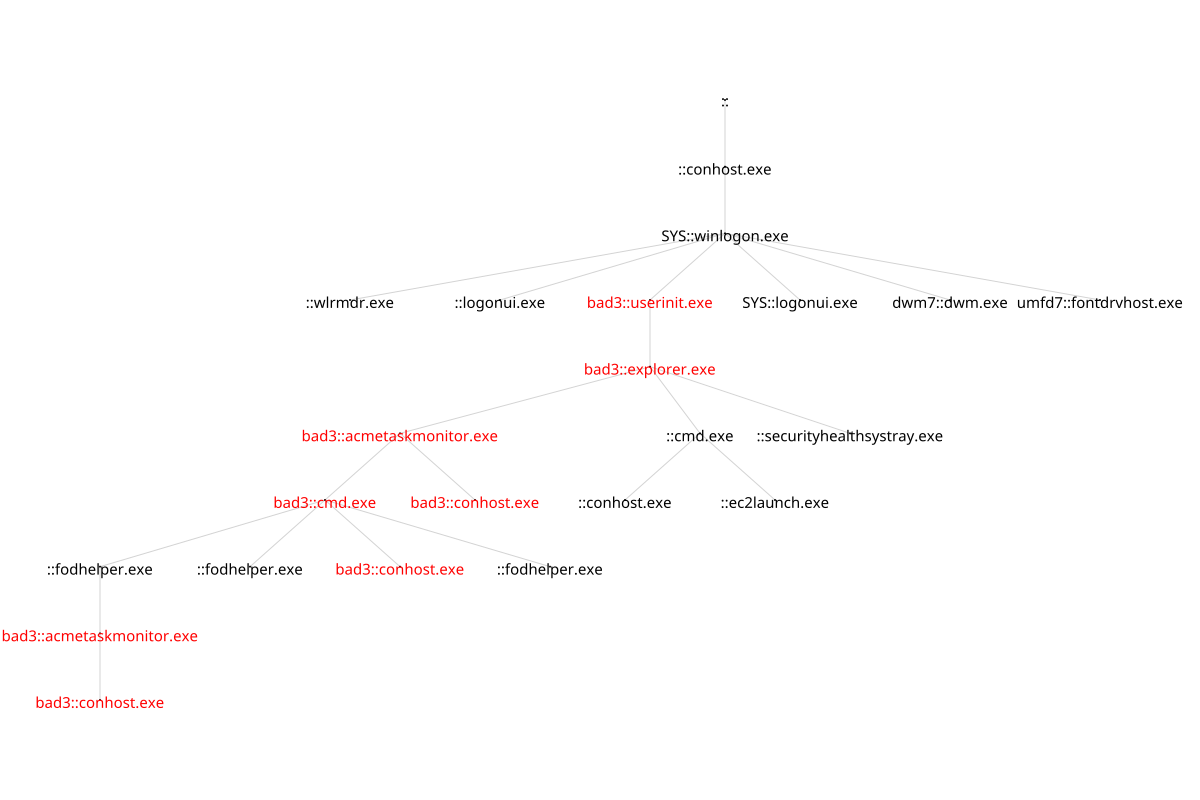

In [23]:
## plot a small one
g = Trees.subgraph(2014)
ly = g.layout_reingold_tilford()
#ig.plot(g, 'bad_tree_1.png', bbox=(1200,800), margin=100, layout=ly, vertex_label_size=15, vertex_size=1, edge_color='lightgrey', edge_arrow_size=0)
ig.plot(g, bbox=(1200,800), margin=100, layout=ly, vertex_label_size=15, vertex_size=1, edge_color='lightgrey', edge_arrow_size=0)


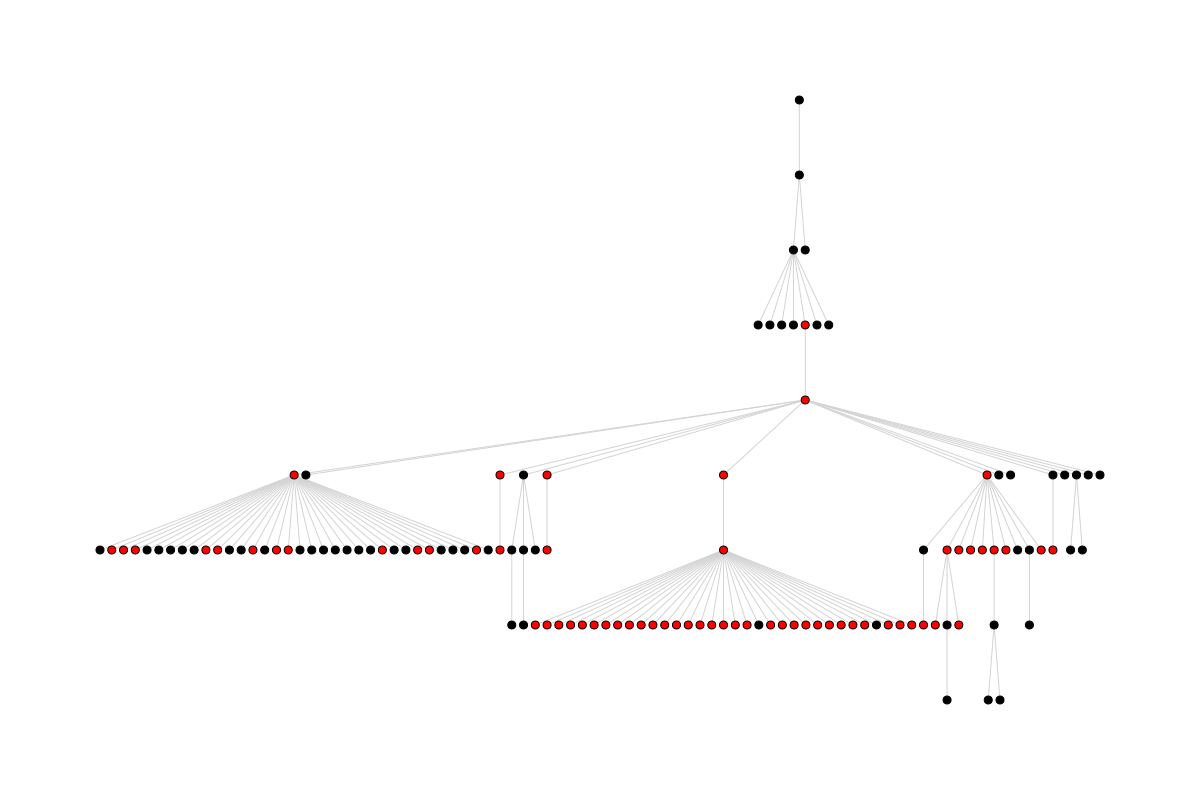

In [24]:
## plot a larger one - do not show the labels
g = Trees.subgraph(14973)
ly = g.layout_reingold_tilford()
#ig.plot(g, 'bad_tree_2.png', bbox=(1200,800), margin=100, layout=ly, vertex_label_size=0, vertex_size=8, edge_color='lightgrey', edge_arrow_size=0)
ig.plot(g, bbox=(1200,800), margin=100, layout=ly, vertex_label_size=0, vertex_size=8, edge_color='lightgrey', edge_arrow_size=0)


# Part II - Build ```process_df``` DataFrame with subtrees and statistics

* 99.98% of components are of size 2 (1,111,052  out of 1,111,278) ...
* 210 process trees contain between 3 and 10k nodes
* 16 have more then 10k nodes

For process tree of size [3,10k], we build every subtree of size 3 or more where root has a process name and for each, we save:
* the tree and root node indices
* the number of nodes, layers, leaves and the distribution of nodes across layers
* the number of splits (parent with 2+ children)
* the results are saved in ```process_df```


### Process tree sizes

In [25]:
## size of the Trees
print('number of PIDs:',len(Trees.membership),'number of components:',len(set(Trees.membership)))
Counter([len(x) for x in Trees]).most_common(12)


number of PIDs: 2884171 number of components: 1111278


[(2, 1111052),
 (3, 94),
 (4, 21),
 (5, 12),
 (12, 11),
 (6, 8),
 (7, 4),
 (13, 4),
 (119, 2),
 (10, 2),
 (20, 2),
 (24610, 1)]

In [26]:
## huge components - we won't use those
sum(np.array([len(x) for x in Trees])>10000)

np.int64(16)

### Main function - build ```process_df``` DataFrame

This takes a few minutes.


In [27]:
%%time
## Trees of size 3+ and up to 10000 ; there are only 210 of those
tree_ids = np.where( (np.array([len(x) for x in Trees])>2) & (np.array([len(x) for x in Trees])<=10000) )[0]

## for those, gather detailed layer statistics
L = []
for i in range(len(tree_ids)):
    g = Trees.subgraph(tree_ids[i])
    if int(sum(np.array(g.degree(mode='in'))==0))==1:
        for v in g.vs:
            if v['process'] != '':
                V, l, p = g.bfs(v.index )
                nodes = len(V)
                splits = sum([x>1 for x in list(Counter(np.array(p)[np.array(p)>=0]).values())])
                leaves = nodes - len(set(np.array(p)[np.array(p)>=0]))
                layers = len(l)-1
                b = len([x for x in g.vs[V]['username'] if x is not None and 'baduser' in x])
                #proc = Counter(g.vs[V]['process'])
                _d = dict()
                for j in range(len(l)-1):
                    _d[j] = Counter(g.vs[V[l[j]:l[j+1]]]['process'])
                x = [tree_ids[i],v.index,v['process'], nodes, layers, np.diff(l), splits, leaves, b, _d]
                L.append(x)
    else:
        print('not a tree:',tree_ids[i])

process_df = pd.DataFrame(L, columns=['tree','root','process', 'nodes', 'layers', 'distribution','splits','leaves','badusers','process_dict'])
## keep trees with 3+ nodes
process_df = process_df[process_df.nodes>2]
process_df['count'] = 1
process_df['split_ratio_nodes'] = process_df['splits'] / process_df['nodes']
process_df['has_bad'] = [int(x>0) for x in process_df['badusers']]
process_df.reset_index(drop=True, inplace=True)
## drop 'unknown' processes
process_df = process_df[process_df['process'] != 'unknown']
print('shape:',process_df.shape)
print('trees with bad user:',sum(process_df.has_bad))
process_df.head()


shape: (2693, 13)
trees with bad user: 131
CPU times: user 2min 20s, sys: 639 ms, total: 2min 20s
Wall time: 2min 20s


,tree,root,process,nodes,layers,distribution,splits,leaves,badusers,process_dict,count,split_ratio_nodes,has_bad
1,7,34,ssm-document-worker.exe,7,2,"[1, 6]",1,6,0,"{0: {'ssm-document-worker.exe': 1}, 1: {'power...",1,0.142857,0
2,7,40,ngentask.exe,4,2,"[1, 3]",1,3,0,"{0: {'ngentask.exe': 1}, 1: {'ngen.exe': 2, 'c...",1,0.250000,0
3,7,42,compattelrunner.exe,5,2,"[1, 4]",1,4,0,"{0: {'compattelrunner.exe': 1}, 1: {'compattel...",1,0.200000,0
4,7,60,ssm-document-worker.exe,12,2,"[1, 11]",1,11,0,"{0: {'ssm-document-worker.exe': 1}, 1: {'power...",1,0.083333,0
5,7,146,compattelrunner.exe,5,2,"[1, 4]",1,4,0,"{0: {'compattelrunner.exe': 1}, 1: {'compattel...",1,0.200000,0


### common process and layer size distribution

The most common (sub)-process trees are very shallow. 


In [28]:
Counter([str(i)+str(j) for i,j in zip (process_df.process,process_df.distribution)]).most_common(20)


[('git.exe[1 2]', 353),
 ('ngentask.exe[1 3]', 284),
 ('bash.exe[1 1 1]', 170),
 ('bash.exe[1 2 2 1]', 134),
 ('taskhostw.exe[1 2 6]', 130),
 ('bash.exe[1 2 1]', 129),
 ('cmd.exe[1 2]', 111),
 ('compattelrunner.exe[1 4]', 80),
 ('compattelrunner.exe[1 2]', 69),
 ('ssm-document-worker.exe[ 1 11]', 47),
 ('winlogon.exe[1 3]', 46),
 ('cmd.exe[1 2 1]', 43),
 ('smss.exe[1 2 3]', 41),
 ('bash.exe[1 1 1 1]', 29),
 ('aws.exe[1 1 1]', 22),
 ('cmd.exe[1 1 1 1]', 17),
 ('cmd.exe[1 1 1]', 17),
 ('downloadfroms3.exe[1 1 1]', 16),
 ('microsoftedgeupdate.exe[1 2 1 4 3]', 14),
 ('setup.exe[1 4 3]', 14)]

###  most common root processes


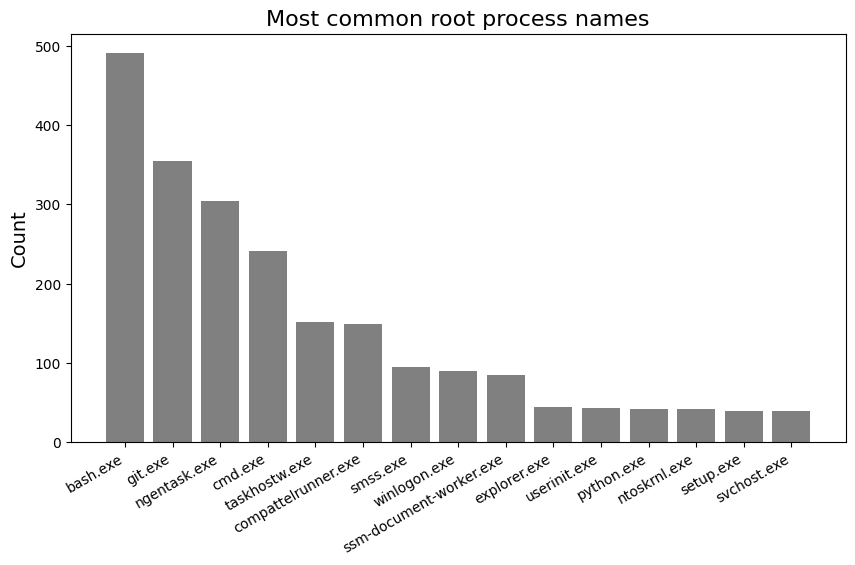

In [29]:
_ctr = Counter(process_df.process)
X = np.array(list(_ctr.keys()))
Y = np.array(list(_ctr.values()))
top = np.argsort(Y)[::-1][:15]
plt.figure(figsize=(10,6))
plt.bar(X[top], Y[top], color='grey')
#plt.xlabel('process')
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=30, ha='right') 
plt.title('Most common root process names',fontsize=16)
plt.subplots_adjust(bottom=0.2)
#plt.savefig('common_root_process.png')
plt.show()

## most common root processes with baduser(s)


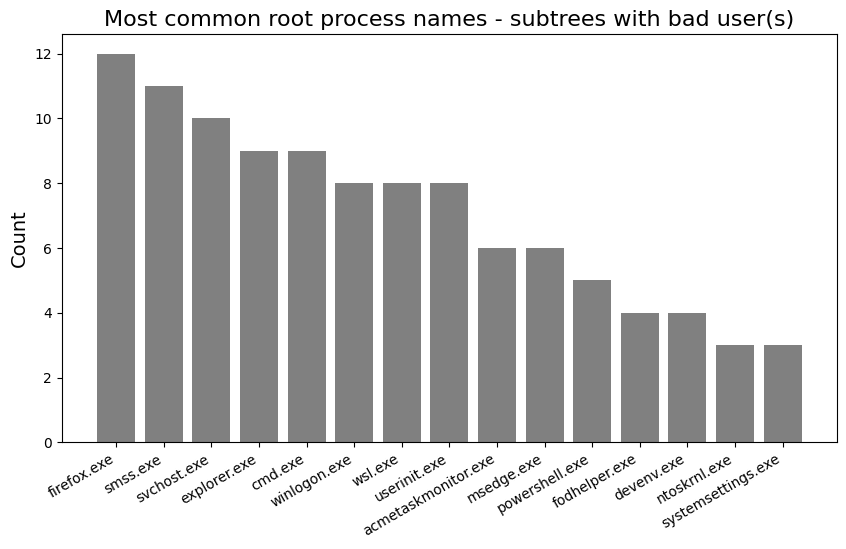

In [30]:
_ctr = Counter(process_df[process_df.has_bad>0].process)
X = np.array(list(_ctr.keys()))
Y = np.array(list(_ctr.values()))
top = np.argsort(Y)[::-1][:15]
plt.figure(figsize=(10,6))
plt.bar(X[top], Y[top], color='grey')
#plt.xlabel('process')
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=30, ha='right') 
plt.title('Most common root process names - subtrees with bad user(s)',fontsize=16)
plt.subplots_adjust(bottom=0.2)
#plt.savefig('common_root_process_bad.png')
plt.show()

### sub-tree depth

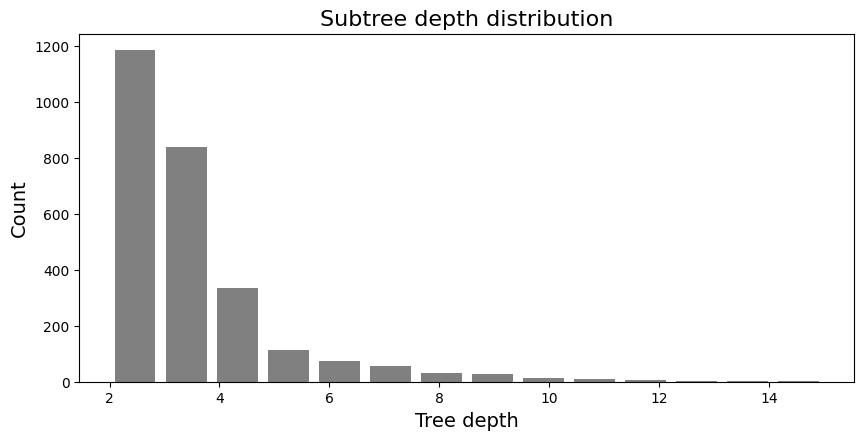

In [31]:
plt.figure(figsize=(10,6))
plt.hist(process_df['layers'],bins=14, rwidth=.8, color='grey')
plt.xlabel('Tree depth', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Subtree depth distribution',fontsize=16)
plt.subplots_adjust(bottom=0.3)
#plt.savefig('subtree_depth.png')
plt.show()

In [32]:
## very few deep (sub)-trees 
process_df[process_df['layers']>10]

,tree,root,process,nodes,layers,distribution,splits,leaves,badusers,process_dict,count,split_ratio_nodes,has_bad
723,722,5,winlogon.exe,159,12,"[1, 8, 1, 9, 92, 5, 4, 3, 27, 5, 3, 1]",9,133,0,"{0: {'winlogon.exe': 1}, 1: {'dwm.exe': 1, 'lo...",1,0.056604,0
746,722,405,smss.exe,1978,14,"[1, 10, 15, 32, 207, 424, 1208, 38, 4, 3, 27, ...",46,1858,40,"{0: {'smss.exe': 1}, 1: {'smss.exe': 9, 'autoc...",1,0.023256,1
758,722,523,smss.exe,161,13,"[1, 2, 8, 1, 9, 92, 5, 4, 3, 27, 5, 3, 1]",10,134,0,"{0: {'smss.exe': 1}, 1: {'winlogon.exe': 1, 'c...",1,0.062112,0
761,722,1075,userinit.exe,151,11,"[1, 1, 9, 92, 5, 4, 3, 27, 5, 3, 1]",8,126,0,"{0: {'userinit.exe': 1}, 1: {'explorer.exe': 1...",1,0.052980,0
771,722,1563,ntoskrnl.exe,2926,15,"[1, 4, 953, 16, 32, 207, 424, 1208, 38, 4, 3, ...",48,2803,40,"{0: {'ntoskrnl.exe': 1}, 1: {'unknown': 1, 'sm...",1,0.016405,1
785,724,4,smss.exe,201,11,"[1, 2, 6, 1, 10, 166, 3, 4, 1, 3, 4]",12,186,119,"{0: {'smss.exe': 1}, 1: {'winlogon.exe': 1, 'c...",1,0.059701,1
788,724,10,smss.exe,848,12,"[1, 13, 18, 50, 8, 59, 606, 35, 25, 13, 14, 6]",63,713,360,"{0: {'smss.exe': 1}, 1: {'smss.exe': 12, 'auto...",1,0.074292,1
864,724,359,smss.exe,281,11,"[1, 2, 6, 1, 13, 241, 6, 6, 1, 2, 2]",14,261,155,"{0: {'smss.exe': 1}, 1: {'winlogon.exe': 1, 'c...",1,0.049822,1
878,724,468,ntoskrnl.exe,852,13,"[1, 4, 13, 18, 50, 8, 59, 606, 35, 25, 13, 14, 6]",64,716,360,"{0: {'ntoskrnl.exe': 1}, 1: {'smss.exe': 1, 'u...",1,0.075117,1
1747,733,345,smss.exe,1336,11,"[1, 14, 27, 51, 193, 409, 434, 149, 42, 14, 2]",80,1133,296,"{0: {'smss.exe': 1}, 1: {'smss.exe': 14}, 2: {...",1,0.059880,1


## Filtering

From the ```process_df``` table, we can filter sub-trees in various ways (size, proportion of splits, etc...). We show a few examples below.


In [33]:
## utility function -- getting a subtree from Trees object
def get_subtree(Trees, tree_id, root_id):
    nodes, _ ,_ = Trees.subgraph(tree_id).bfs(root_id)
    g = Trees.subgraph(tree_id).subgraph(nodes)
    g["ly"] = g.layout_reingold_tilford() ## save a layout for plotting
    return g

### Example 1: small subtrees with large number of splits

We also visualize a few. Node labels are: ```short_username::process_name```


In [34]:
## extract
_df = process_df[ (process_df['nodes']>=10) & (process_df['nodes']<=20) & (process_df.split_ratio_nodes>.3) ]
_df

,tree,root,process,nodes,layers,distribution,splits,leaves,badusers,process_dict,count,split_ratio_nodes,has_bad
797,724,34,nyancat.exe,18,7,"[1, 2, 3, 4, 1, 3, 4]",6,11,9,"{0: {'nyancat.exe': 1}, 1: {'conhost.exe': 1, ...",1,0.333333,1
798,724,36,acmetaskmonitor.exe,16,6,"[1, 3, 4, 1, 3, 4]",5,10,7,"{0: {'acmetaskmonitor.exe': 1}, 1: {'fodhelper...",1,0.312500,1
830,724,184,acmetaskmonitor.exe,15,6,"[1, 3, 6, 1, 2, 2]",5,9,4,"{0: {'acmetaskmonitor.exe': 1}, 1: {'cmd.exe':...",1,0.333333,1
849,724,251,cmd.exe,13,5,"[1, 4, 1, 3, 4]",4,8,5,"{0: {'cmd.exe': 1}, 1: {'fodhelper.exe': 3, 'c...",1,0.307692,1
880,724,573,nyancat.exe,17,7,"[1, 2, 3, 6, 1, 2, 2]",6,10,6,"{0: {'nyancat.exe': 1}, 1: {'acmetaskmonitor.e...",1,0.352941,1
1680,731,132,smss.exe,16,6,"[1, 2, 5, 1, 3, 4]",5,10,0,"{0: {'smss.exe': 1}, 1: {'winlogon.exe': 1, 'c...",1,0.312500,0
2423,14156,40,smss.exe,16,6,"[1, 2, 5, 1, 3, 4]",5,10,0,"{0: {'smss.exe': 1}, 1: {'winlogon.exe': 1, 'c...",1,0.312500,0
2491,26424,180,smss.exe,12,6,"[1, 2, 4, 1, 2, 2]",4,7,0,"{0: {'smss.exe': 1}, 1: {'winlogon.exe': 1, 'c...",1,0.333333,0


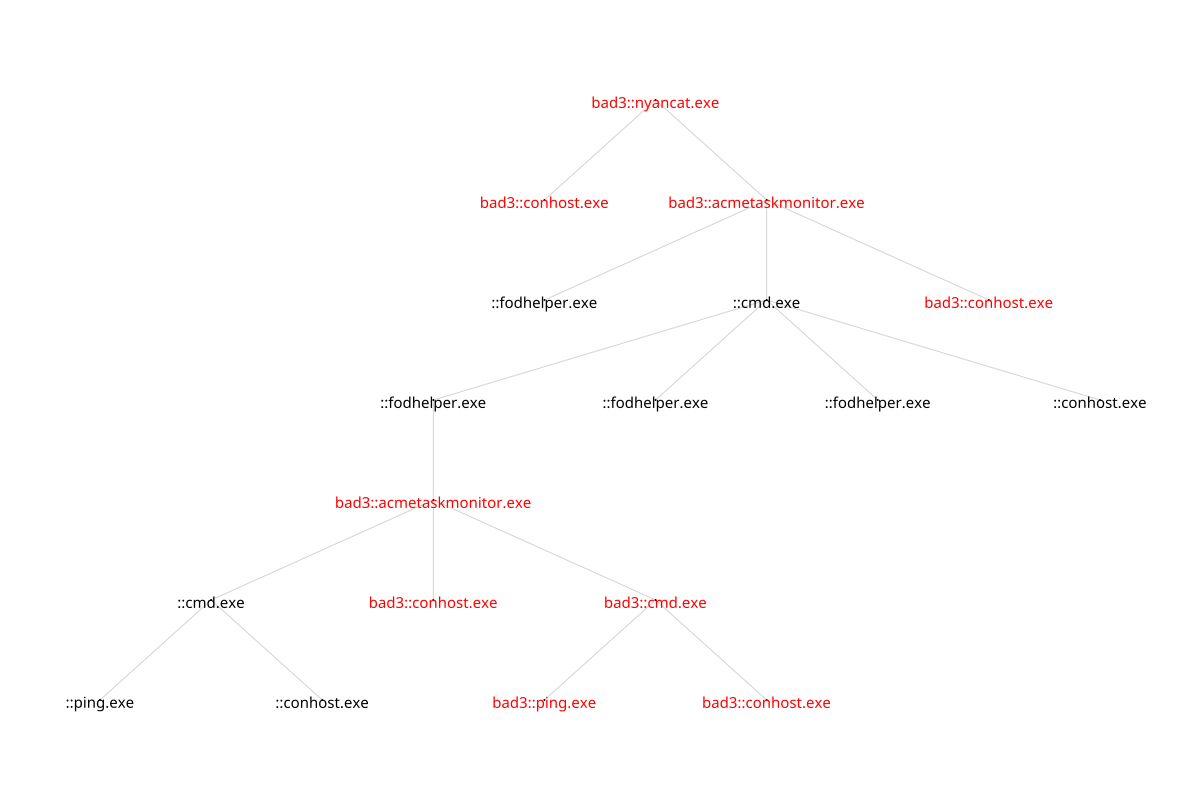

In [35]:
## visualize 
sg = get_subtree(Trees, 724, 34)
#ig.plot(sg, 'tree_bad_splits.png', bbox=(1200,800), margin=100, layout=sg['ly'], vertex_label_size=15, vertex_size=1, edge_color='lightgrey', edge_arrow_size=0)
ig.plot(sg, bbox=(1200,800), margin=100, layout=sg['ly'], vertex_label_size=15, vertex_size=1, edge_color='lightgrey', edge_arrow_size=0)


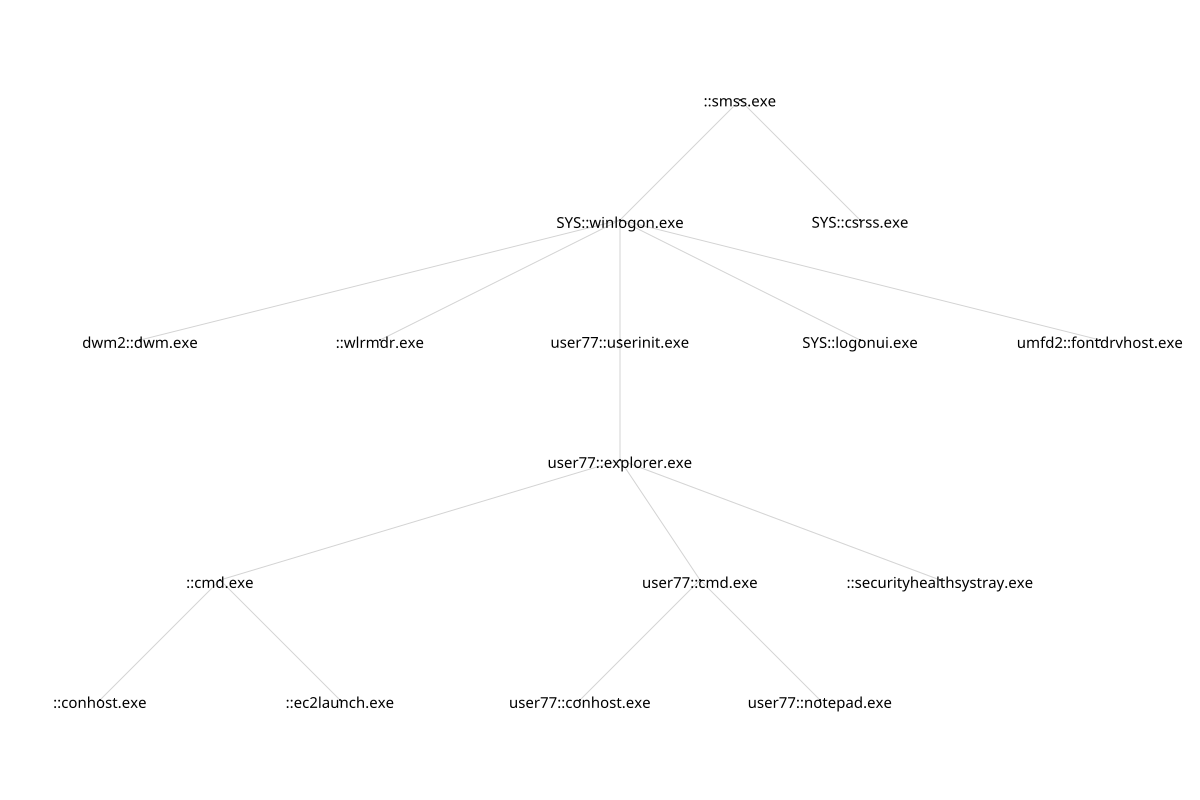

In [36]:
## visualize
sg = get_subtree(Trees, 731, 132)
ig.plot(sg, bbox=(1200,800), margin=100, layout=sg['ly'], vertex_label_size=15, vertex_size=1, edge_color='lightgrey', edge_arrow_size=0)


### Example 2 - small subtrees with few split nodes


In [37]:
## extract
_df = process_df[ (process_df['nodes']>=10) & (process_df['nodes']<=20) & (process_df.leaves<5) & (process_df.split_ratio_nodes<.1) ]
_df

,tree,root,process,nodes,layers,distribution,splits,leaves,badusers,process_dict,count,split_ratio_nodes,has_bad
773,722,1566,setup-stub.exe,11,6,"[1, 1, 1, 4, 3, 1]",1,4,0,"{0: {'setup-stub.exe': 1}, 1: {'download.exe':...",1,0.090909,0


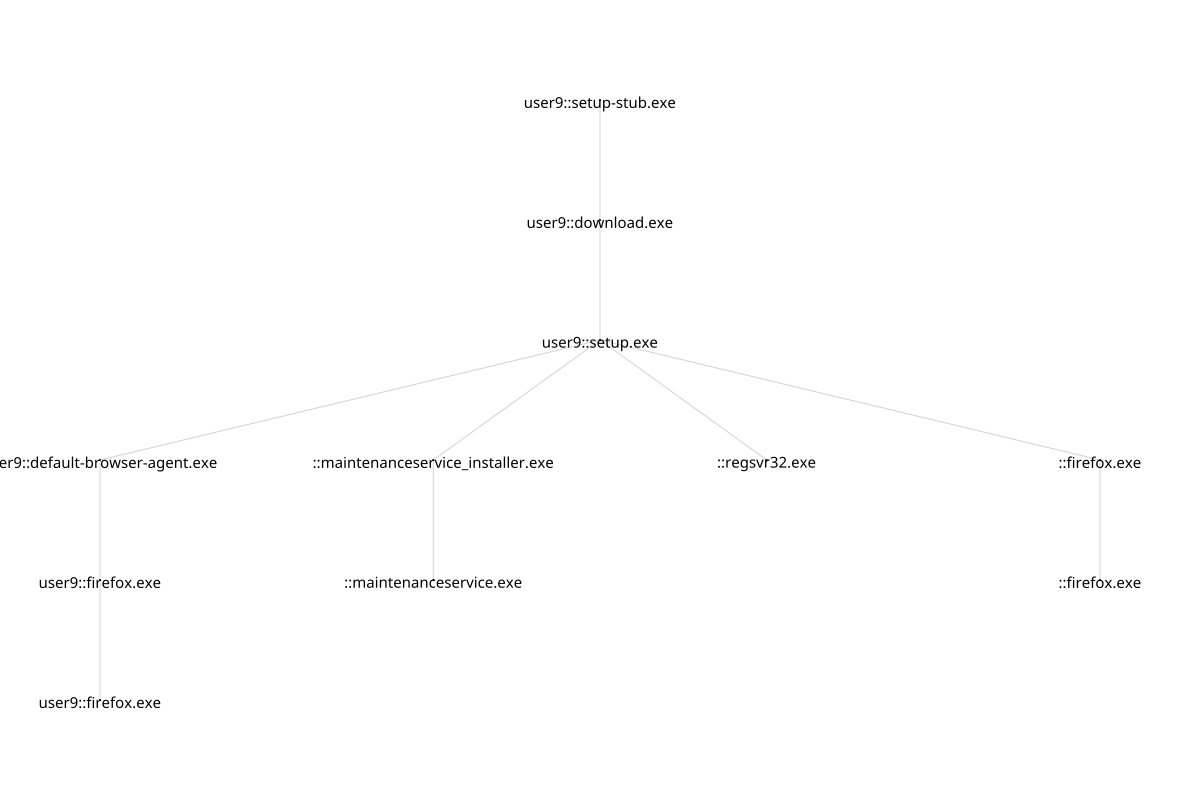

In [38]:
## visualize
sg = get_subtree(Trees, 722, 1566)
ig.plot(sg, bbox=(1200,800), margin=100, layout=sg['ly'], vertex_label_size=15, vertex_size=1, edge_color='lightgrey', edge_arrow_size=0)


# Part III - Validation experiments

We run two simple experiments on the process trees listed in ```process_df```:

* pick the 9 most common root processes and **cluster** the corresponding process trees via bag-of-features and the Szymkiewicz-Simpson (overlap) similarity score.
* using the above similarity score, look at the number of **nearest neighbours** process trees that contain some bad user ; compare this value for trees with/without bad users.


## process tree clustering via bag of features

We consider subtrees labelled with the root's process name.

We build bag of features made up of every process in the tree, by concatenating the following:

* process name
* layer (distance from root)
* counter (useful to consider multiple occurrences of the same process at the same layer)


In [39]:
## compute bag of features
def subtree_features(sg):
    root = np.where(np.array(sg.degree(mode='in'))==0)[0][0]
    V, L, _ = sg.bfs(root)
    F = []
    for i in range(len(L)-1):
        P = []
        for j in np.arange(L[i],L[i+1]):
            P.append(sg.vs[V[j]]['process'])
        C = Counter(P)
        keys = list(C.keys())
        vals = list(C.values())
        for j in range(len(keys)):
            for k in range(vals[j]):
                F.append(str(i)+'::'+keys[j]+'::'+str(k)) 
    return set(F)

## overlap coefficient (aka Szymkiewicz-Simpson)
def my_sim(a,b):
    return len(a.intersection(b))/min(len(a),len(b))


In [40]:
## example of a subtree and its features
sg = get_subtree(Trees, 731, 132)
subtree_features(sg)


{'0::smss.exe::0',
 '1::csrss.exe::0',
 '1::winlogon.exe::0',
 '2::dwm.exe::0',
 '2::fontdrvhost.exe::0',
 '2::logonui.exe::0',
 '2::userinit.exe::0',
 '2::wlrmdr.exe::0',
 '3::explorer.exe::0',
 '4::cmd.exe::0',
 '4::cmd.exe::1',
 '4::securityhealthsystray.exe::0',
 '5::conhost.exe::0',
 '5::conhost.exe::1',
 '5::ec2launch.exe::0',
 '5::notepad.exe::0'}

In [41]:
%%time
## build bag of features for every subtree - this takes several minutes
Features = []
for t,r in zip(process_df.tree, process_df.root):
    sg = get_subtree(Trees, t, r)
    Features.append(subtree_features(sg))
    

CPU times: user 10min 37s, sys: 481 ms, total: 10min 37s
Wall time: 10min 37s


In [42]:
## consider the most common root process names
top_process = 9
P = list(process_df['process'])
mc = set([x[0] for x in Counter(P).most_common(top_process)])
P_subset = [p for p in P if p in mc]
F_subset = [f for (p,f) in zip(P,Features) if p in mc]

## compute similarities
l = len(F_subset)
S = np.zeros(shape=(l,l))
for i in range(len(F_subset)-1):
    for j in np.arange(i+1,len(F_subset)):
        s = my_sim(F_subset[i],F_subset[j])
        S[i,j] = S[j,i] = s


In [43]:
## cluster - set the correct number of clusters
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=top_process, metric='precomputed', linkage='complete')
model.fit(1-S)

,n_clusters,9
,metric,'precomputed'
,memory,None
,connectivity,None
,compute_full_tree,'auto'
,linkage,'complete'
,distance_threshold,None
,compute_distances,False


In [44]:
## list cluster compositions
for s in range(top_process):
    print(Counter([P_subset[i] for i in np.where(model.labels_==s)[0]]))


Counter({'bash.exe': 482})
Counter({'smss.exe': 94})
Counter({'cmd.exe': 237})
Counter({'winlogon.exe': 89})
Counter({'taskhostw.exe': 151, 'cmd.exe': 3})
Counter({'ngentask.exe': 304, 'compattelrunner.exe': 149})
Counter({'bash.exe': 7, 'cmd.exe': 1})
Counter({'ssm-document-worker.exe': 84})
Counter({'git.exe': 355, 'bash.exe': 2})


## nearest neighbours with badusers as labels


In [45]:
## compute similarities
l = len(Features)
S = np.zeros(shape=(l,l))
for i in range(len(Features)-1):
    for j in np.arange(i+1,len(Features)):
        s = my_sim(Features[i],Features[j])
        S[i,j] = S[j,i] = s

In [46]:
from sklearn.neighbors import NearestNeighbors as NN
model = NN(n_neighbors=11, metric='precomputed')
model.fit(1-S)


,n_neighbors,11
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'precomputed'
,p,2
,metric_params,None
,n_jobs,None


In [47]:
## size of intersections - NNs and 
_, indices = model.kneighbors()
Bad = set(np.where(process_df.has_bad)[0])
bad_nn = [len(set(v).intersection(Bad)) for v in indices]

## average number of NN trees with baduser
_temp = pd.DataFrame(np.array([list(process_df.has_bad) , bad_nn]).T,columns=['bad','bad_nn'])
_temp.groupby(by='bad').mean()


,bad_nn
bad,
0,0.272053
1,2.679389


### Quick EDA

Top non-baduser trees with several baduser NNs have the same shape, a sequence of three 'wsl.exe' processes.
    

In [48]:
_temp.sort_values(by='bad_nn', ascending=False).head(5)


,bad,bad_nn
1710,0,10
1712,0,10
1730,1,9
1729,0,9
1747,1,9


In [49]:
list(process_df.process_dict)[1710]

{0: Counter({'wsl.exe': 1}),
 1: Counter({'wsl.exe': 1}),
 2: Counter({'wsl.exe': 1})}

# Part IV - Experiments for paper - Applying Algorithm 1

Basic Matching Algorithm from: "Finding Meaningful Paths in Trees" (M. Le, P. Pralat, A. Smith and F. Theberge), in preparation. 
This algorithm finds matching paths in trees using node labels.

In [50]:
import gw_matcher as gwm ## Algorithm 1

## modified utility function -- getting a subtree from Trees object and re-ordering the indices as BFS (required by gw_matcher)
def get_ordered_subtree(Trees, tree_id, root_id):
    g = Trees.subgraph(tree_id)
    nodes, _ , parent = g.bfs(root_id)
    G = ig.Graph(directed=True)
    names = [str(g.vs['name'][i]) for i in nodes]
    process = [g.vs['process'][i] for i in nodes]
    lab_col = [g.vs['label_color'][i] for i in nodes]
    lab = [g.vs['label'][i] for i in nodes]
    col = [g.vs['color'][i] for i in nodes]
    G.add_vertices(names, attributes={'process':process, 'label_color':lab_col, 'color':col,'label':lab})
    E = [(str(g.vs['name'][parent[i]]),str(g.vs['name'][i])) for i in nodes if parent[i]>=0]
    G.add_edges(E)    
    G["ly"] = G.layout_reingold_tilford() ## save a layout for plotting
    return G


### Example 1 - two trees with a common path

* we use process names as node labels
* two trees have a common sequence: ```conhost-winlogon-userinit-explorer-cmd-conhost```
* one of those contains a bad user


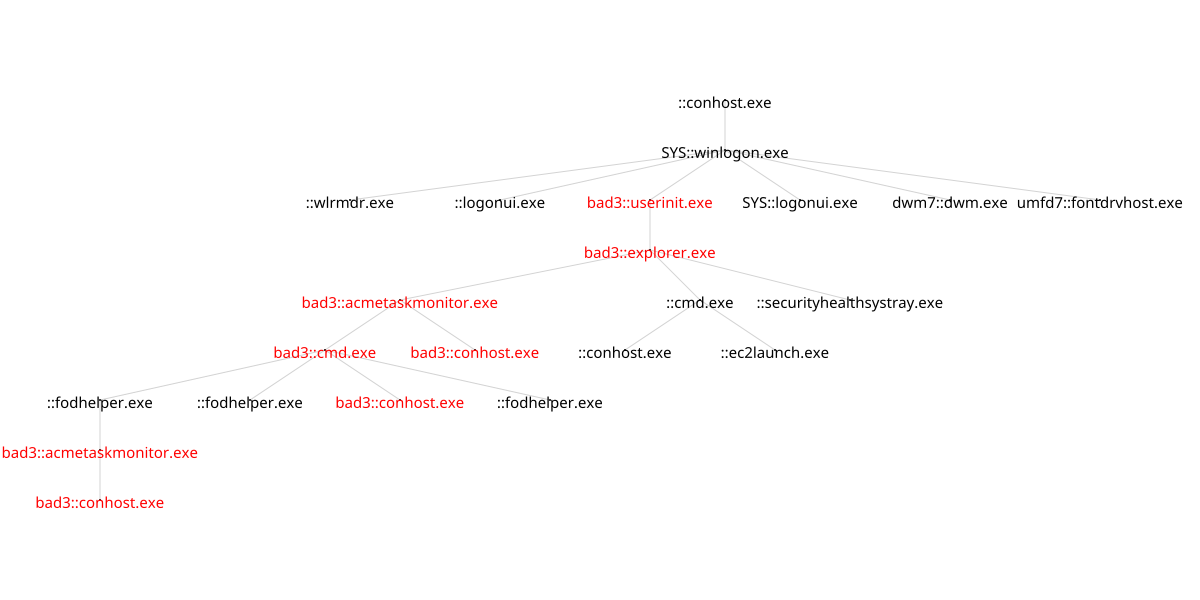

In [51]:
## visualize
sg = get_subtree(Trees, 2014, 7)
#ig.plot(sg, 'tree_1.png', bbox=(1200,600), margin=100, layout=sg['ly'], vertex_label_size=15, vertex_size=1, edge_color='lightgrey', edge_arrow_size=0)
ig.plot(sg, bbox=(1200,600), margin=100, layout=sg['ly'], vertex_label_size=15, vertex_size=1, edge_color='lightgrey', edge_arrow_size=0)


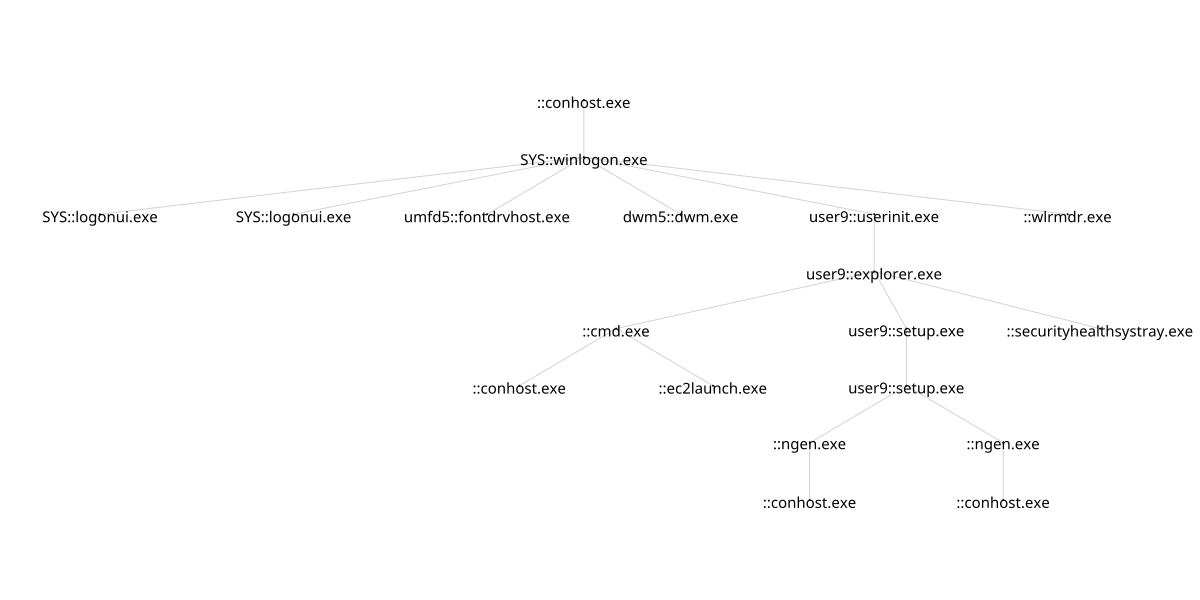

In [52]:
## visualize
sg = get_subtree(Trees, 115349, 5)
#ig.plot(sg, 'tree_2.png', bbox=(1200,600), margin=100, layout=sg['ly'], vertex_label_size=15, vertex_size=1, edge_color='lightgrey', edge_arrow_size=0)
ig.plot(sg, bbox=(1200,600), margin=100, layout=sg['ly'], vertex_label_size=15, vertex_size=1, edge_color='lightgrey', edge_arrow_size=0)


### Example 2 - pick a tree with baduser, find closest matches (longest common path)

* restrict to small trees for visualisation
* select tree with 6+ layers
* look for other process sub-trees with matching path(s) of at least 6 nodes
* keep hits without a baduser
                 

In [53]:
## filter subtrees with badusers
process_df[(process_df.nodes<30) & (process_df.layers>5)].sort_values(by='badusers', ascending=False).head(10)


,tree,root,process,nodes,layers,distribution,splits,leaves,badusers,process_dict,count,split_ratio_nodes,has_bad
797,724,34,nyancat.exe,18,7,"[1, 2, 3, 4, 1, 3, 4]",6,11,9,"{0: {'nyancat.exe': 1}, 1: {'conhost.exe': 1, ...",1,0.333333,1
2226,2014,7,conhost.exe,22,9,"[1, 1, 6, 1, 3, 4, 4, 1, 1]",5,13,8,"{0: {'conhost.exe': 1}, 1: {'winlogon.exe': 1}...",1,0.227273,1
2227,2014,9,winlogon.exe,21,8,"[1, 6, 1, 3, 4, 4, 1, 1]",5,13,8,"{0: {'winlogon.exe': 1}, 1: {'wlrmdr.exe': 1, ...",1,0.238095,1
2228,2014,18,userinit.exe,15,7,"[1, 1, 3, 4, 4, 1, 1]",4,8,8,"{0: {'userinit.exe': 1}, 1: {'explorer.exe': 1...",1,0.266667,1
807,724,71,smss.exe,16,6,"[1, 2, 6, 1, 3, 3]",4,10,7,"{0: {'smss.exe': 1}, 1: {'csrss.exe': 1, 'winl...",1,0.250000,1
798,724,36,acmetaskmonitor.exe,16,6,"[1, 3, 4, 1, 3, 4]",5,10,7,"{0: {'acmetaskmonitor.exe': 1}, 1: {'fodhelper...",1,0.312500,1
2224,2014,3,explorer.exe,14,6,"[1, 3, 4, 4, 1, 1]",4,8,7,"{0: {'explorer.exe': 1}, 1: {'acmetaskmonitor....",1,0.285714,1
880,724,573,nyancat.exe,17,7,"[1, 2, 3, 6, 1, 2, 2]",6,10,6,"{0: {'nyancat.exe': 1}, 1: {'acmetaskmonitor.e...",1,0.352941,1
830,724,184,acmetaskmonitor.exe,15,6,"[1, 3, 6, 1, 2, 2]",5,9,4,"{0: {'acmetaskmonitor.exe': 1}, 1: {'cmd.exe':...",1,0.333333,1
1712,733,132,systemsettings.exe,19,6,"[1, 1, 1, 6, 8, 2]",2,8,1,"{0: {'systemsettings.exe': 1}, 1: {'uninstall....",1,0.105263,1


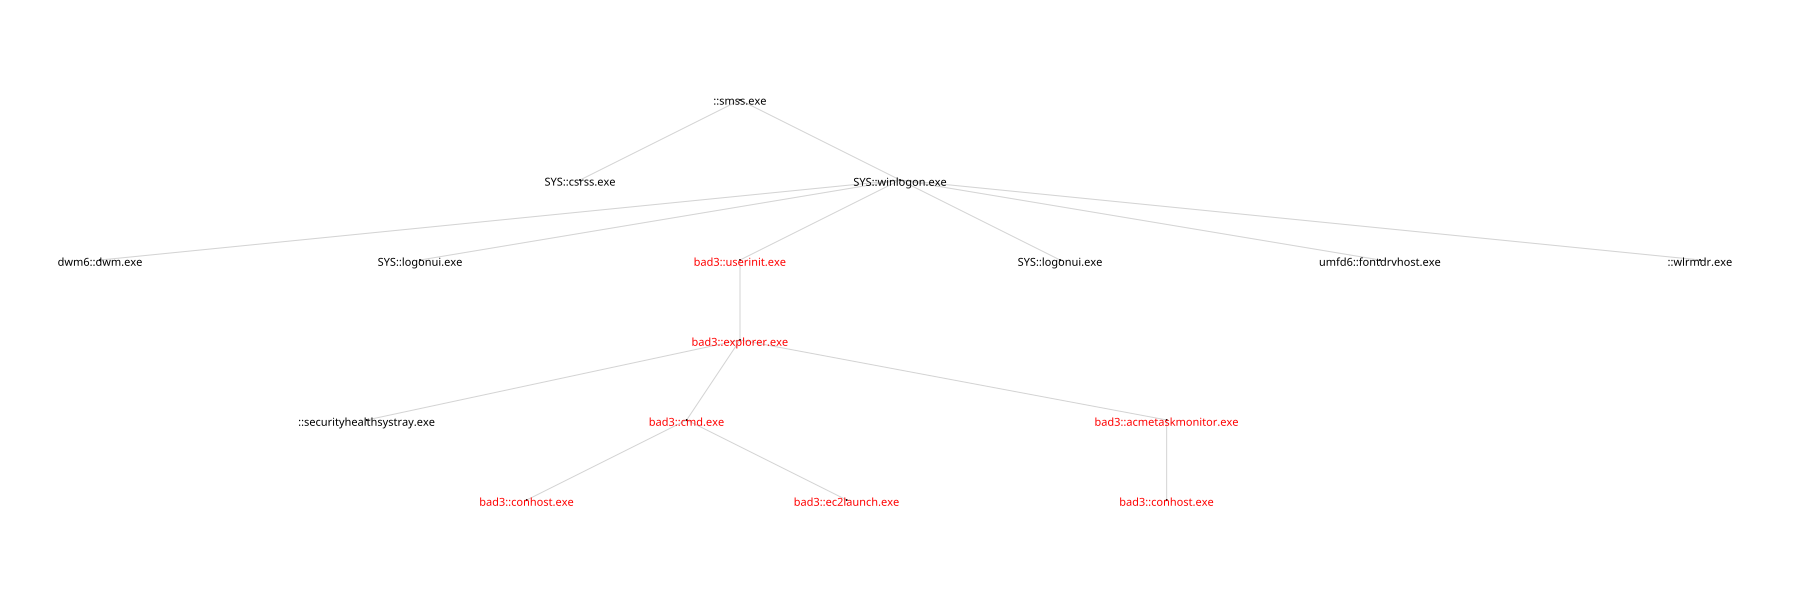

In [54]:
## pick one and visualize
tree = 724
root = 71
sg1 = get_subtree(Trees, tree, root)
#ig.plot(sg1, 'tree_3.png', bbox=(1800,600), layout=sg1['ly'], margin=100, vertex_label_size=9, vertex_size=1, edge_color='lightgrey', edge_arrow_size=0)
ig.plot(sg1, bbox=(1800,600), layout=sg1['ly'], margin=100, vertex_label_size=11, vertex_size=1, edge_color='lightgrey', edge_arrow_size=0)


In [55]:
%%time
## get top hits

## base tree
sg1 = get_ordered_subtree(Trees, tree, root) ## sub-tree above with required DFS labelling

## filter subtrees and apply Algorithm 1 (basic matcher)
_df = process_df[ (process_df.layers >= 6) & (process_df.nodes < 40) ]
T = list(_df.tree)
R = list(_df.root)
L = list(_df.layers)
B = list(_df.has_bad)
Results = []
for i in range(len(T)):
    if T[i] != tree:
        sg2 = get_ordered_subtree(Trees, T[i], R[i])
        _, score = gwm.basic_matcher(sg1, sg2, phi_name='process') ## node feature == process name
        if score >= 6: ## required min common path length
            if B[i] == 0: ## look for subtrees without a baduser
                Results.append([T[i],R[i],L[i],sg2.vcount(),sg2.vs[0]['process'],int(score)])
results_df = pd.DataFrame(Results, columns=['tree','root','layers','nodes','process','score'])
results_df.sort_values(by='nodes')


CPU times: user 6.18 s, sys: 51.7 ms, total: 6.23 s
Wall time: 6.23 s


,tree,root,layers,nodes,process,score
10,26424,180,6,12,smss.exe,6
1,722,7,6,14,smss.exe,6
11,733242,16,10,14,smss.exe,6
2,722,11,6,14,smss.exe,6
8,13059,173,7,15,smss.exe,6
9,14156,40,6,16,smss.exe,6
4,731,132,6,16,smss.exe,6
7,3348,68,10,20,smss.exe,6
3,728,101,7,24,smss.exe,6
5,733,14,7,24,smss.exe,6


#### visualize - highlight common path

* pick one of the hits from the table above
  

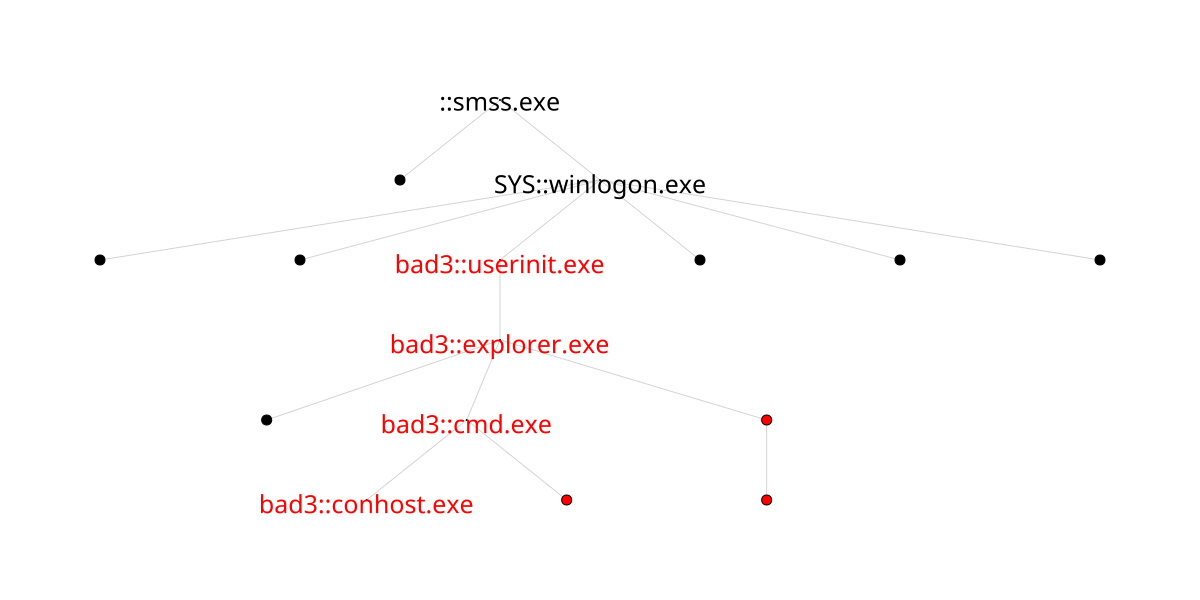

In [56]:
## pick one and visualize common path
tree = 733242
root = 16
sg2 = get_ordered_subtree(Trees, tree, root)
paths, score = gwm.basic_matcher(sg1, sg2, phi_name='process') ## node feature == process name

## plot reference tree (with baduser)
path = [int(x[0]) for x in paths]
sg1.vs['vertex_size'] = 10
sg1.vs['vertex_label_size'] = 1
for i in path:
    sg1.vs[i]['vertex_size'] = 1
    sg1.vs[i]['vertex_label_size'] = 25
ig.plot(sg1, "algo1_1.png",
        bbox=(1200,600), layout=sg1['ly'], margin=100, 
        vertex_size=sg1.vs['vertex_size'], 
        vertex_label=sg1.vs['label'], 
        vertex_label_size=sg1.vs['vertex_label_size'], 
        edge_color='lightgrey', edge_arrow_size=0)


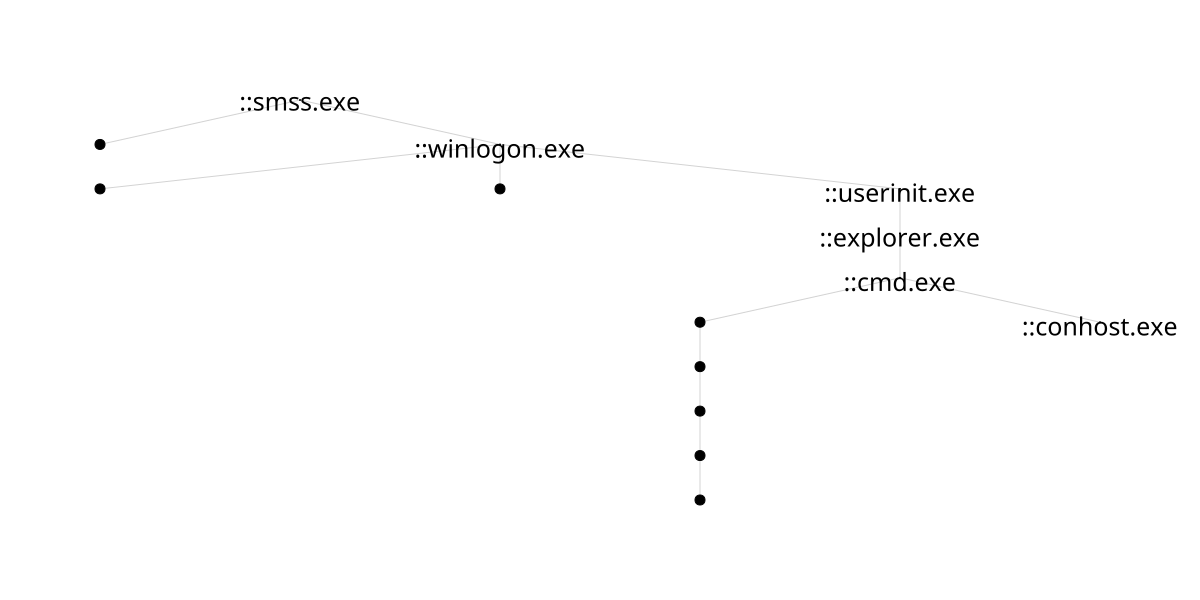

In [57]:
## plot top scoring tree
path = [int(x[1]) for x in paths]
sg2.vs['vertex_size'] = 10
sg2.vs['vertex_label_size'] = 1
for i in path:
    sg2.vs[i]['vertex_size'] = 1
    sg2.vs[i]['vertex_label_size'] = 25
ig.plot(sg2, "algo1_2.png",
        bbox=(1200,600), layout=sg2['ly'], margin=100, 
        vertex_size=sg2.vs['vertex_size'], 
        vertex_label=sg2.vs['label'], 
        vertex_label_size=sg2.vs['vertex_label_size'], 
        edge_color='lightgrey', edge_arrow_size=0)


## Example 3 - using more detailed labels

* for the node labels, we use both the username and process name
* all ```userxx``` and ```badxx``` (```x``` are digits) are mapped to the same string ```user```


In [58]:
import re

## list (tree,root) with baduser
trees = list(process_df[(process_df.nodes<40) & (process_df.layers>4) & (process_df.badusers>0)].tree)
roots = list(process_df[(process_df.nodes<40) & (process_df.layers>4) & (process_df.badusers>0)].root)
for (tree,root) in zip(trees,roots):
    print(tree,root)

724 34
724 36
724 71
724 89
724 184
724 230
724 251
724 284
724 573
733 32
733 132
733 645
733 724
733 940
2014 2
2014 3
2014 7
2014 9
2014 18


In [59]:
%%time
## pick one as base tree
tree = 724
root = 71
sg1 = get_ordered_subtree(Trees, tree, root) ## sub-tree above with required DFS labelling
sg1.vs['newlabel'] = [re.sub(r'user\d+::','user::',x) for x in sg1.vs['label']]
sg1.vs['newlabel'] = [re.sub(r'bad\d+::','user::',x) for x in sg1.vs['newlabel']]

## filter subtrees and apply Algorithm 1 (basic matcher)
_df = process_df[ (process_df.layers >= 4) & (process_df.nodes < 40) ]
T = list(_df.tree)
R = list(_df.root)
L = list(_df.layers)
B = list(_df.has_bad)
Results = []
for i in range(len(T)):
    if T[i] != tree:
        sg2 = get_ordered_subtree(Trees, T[i], R[i])
        sg2.vs['newlabel'] = [re.sub(r'user\d+::','user::',x) for x in sg2.vs['label']]
        _, score = gwm.basic_matcher(sg1, sg2, phi_name='newlabel') ## node feature == process name
        if score >= 6: ## required min path length
            if B[i] == 0: ## look for subtrees without a baduser
                Results.append([T[i],R[i],L[i],sg2.vcount(),sg2.vs[0]['process'],int(score)])
results_df = pd.DataFrame(Results, columns=['tree','root','layers','nodes','process','score'])
results_df.sort_values(by='nodes')


CPU times: user 47.1 s, sys: 65.9 ms, total: 47.2 s
Wall time: 47.2 s


,tree,root,layers,nodes,process,score
0,731,132,6,16,smss.exe,6
2,14156,40,6,16,smss.exe,6
1,3348,68,10,20,smss.exe,6


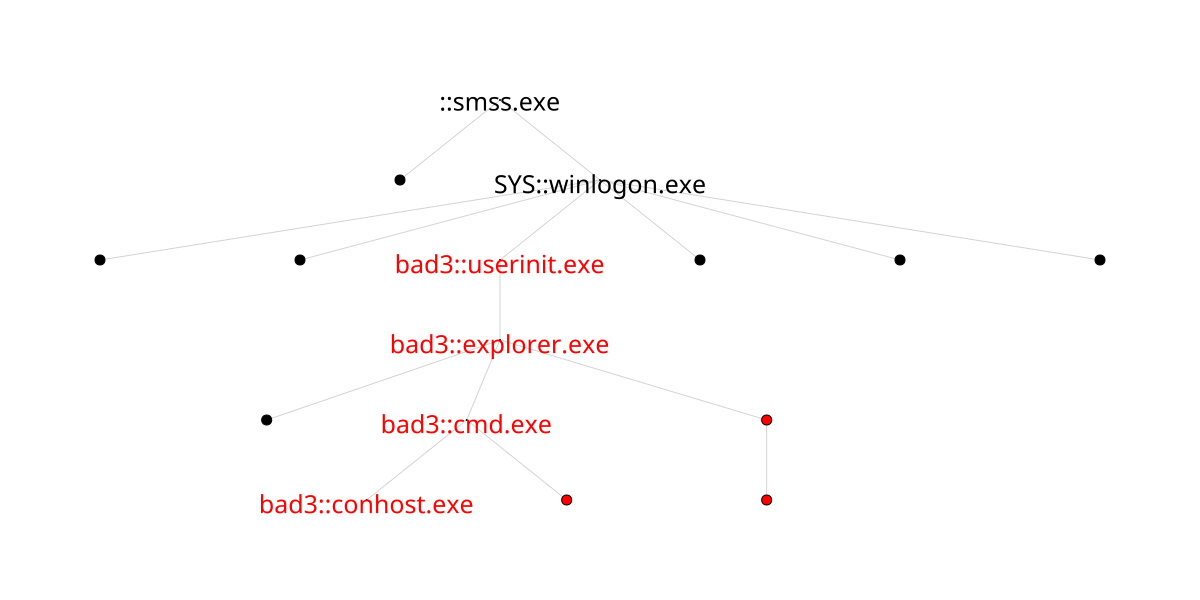

In [60]:
## pick one of the top hits and visualize common path
tree = 3348
root = 68
sg2 = get_ordered_subtree(Trees, tree, root)
sg2.vs['newlabel'] = [re.sub(r'user\d+::','user::',x) for x in sg2.vs['label']]
paths, score = gwm.basic_matcher(sg1, sg2, phi_name='newlabel') ## node feature == process name

## plot reference tree
path = [int(x[0]) for x in paths]
sg1.vs['vertex_size'] = 10
sg1.vs['vertex_label_size'] = 1
for i in path:
    sg1.vs[i]['vertex_size'] = 1
    sg1.vs[i]['vertex_label_size'] = 25
ig.plot(sg1, bbox=(1200,600), layout=sg1['ly'], margin=100, 
        vertex_size=sg1.vs['vertex_size'], 
        vertex_label=sg1.vs['label'], 
        vertex_label_size=sg1.vs['vertex_label_size'], 
        edge_color='lightgrey', edge_arrow_size=0)

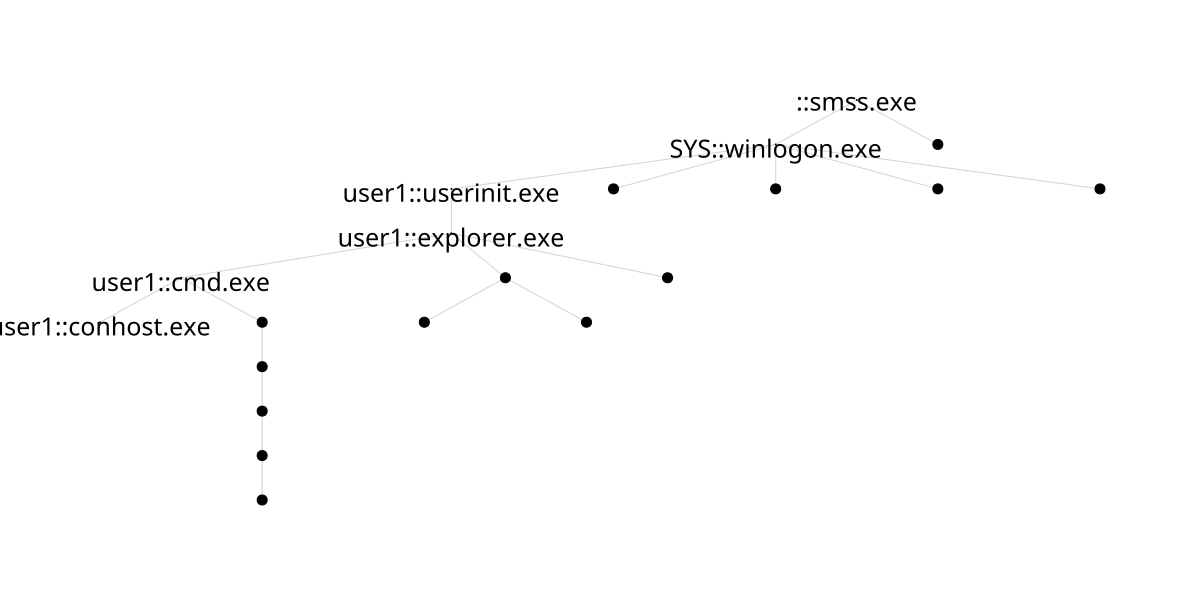

In [61]:
## plot top scoring tree
path = [int(x[1]) for x in paths]
sg2.vs['vertex_size'] = 10
sg2.vs['vertex_label_size'] = 1
for i in path:
    sg2.vs[i]['vertex_size'] = 1
    sg2.vs[i]['vertex_label_size'] = 25
ig.plot(sg2, "algo1_3.png", 
        bbox=(1200,600), layout=sg2['ly'], margin=100, 
        vertex_size=sg2.vs['vertex_size'], 
        vertex_label=sg2.vs['label'], 
        vertex_label_size=sg2.vs['vertex_label_size'], 
        edge_color='lightgrey', edge_arrow_size=0)

## Example 4 - New scoring function

* so far, we used a binary score for the node labels (match or not)
* we define a new score giving partial marks for matching process only, and full mark for matching process and user


In [62]:
def split_match(a,b):
    A = a.split('::')
    B = b.split('::')
    alpha = .75
    return (1-alpha)*int(A[0]==B[0]) + alpha*int(A[1]==B[1])


In [63]:
%%time
## pick one as base tree
tree = 724
root = 71
sg1 = get_ordered_subtree(Trees, tree, root) ## sub-tree above with required DFS labelling
sg1.vs['newlabel'] = [re.sub(r'user\d+::','user::',x) for x in sg1.vs['label']]
sg1.vs['newlabel'] = [re.sub(r'bad\d+::','user::',x) for x in sg1.vs['newlabel']]

## filter subtrees and apply Algorithm 1 (basic matcher)
_df = process_df[ (process_df.layers >= 4) & (process_df.nodes < 80) ]
T = list(_df.tree)
R = list(_df.root)
L = list(_df.layers)
B = list(_df.has_bad)
Results = []
for i in range(len(T)):
    if T[i] != tree:
        sg2 = get_ordered_subtree(Trees, T[i], R[i])
        sg2.vs['newlabel'] = [re.sub(r'user\d+::','user::',x) for x in sg2.vs['label']]
        _, score = gwm.basic_matcher(sg1, sg2, phi_name='newlabel', w=split_match) ## node feature == process name
        if score > 5: ## required min path length
            if B[i] == 0: ## look for subtrees without a baduser
                Results.append([T[i],R[i],L[i],sg2.vcount(),sg2.vs[0]['process'],score])
results_df = pd.DataFrame(Results, columns=['tree','root','layers','nodes','process','score'])
results_df.sort_values(by='nodes')


CPU times: user 52.5 s, sys: 114 ms, total: 52.6 s
Wall time: 52.6 s


,tree,root,layers,nodes,process,score
14,26424,180,6,12,smss.exe,5.50
3,722,11,6,14,smss.exe,5.50
2,722,7,6,14,smss.exe,5.50
11,13059,173,7,15,smss.exe,5.75
5,731,132,6,16,smss.exe,6.00
12,14156,40,6,16,smss.exe,6.00
10,3348,68,10,20,smss.exe,6.00
4,728,101,7,24,smss.exe,5.75
6,733,14,7,24,smss.exe,5.50
1,12,928,7,31,smss.exe,5.75


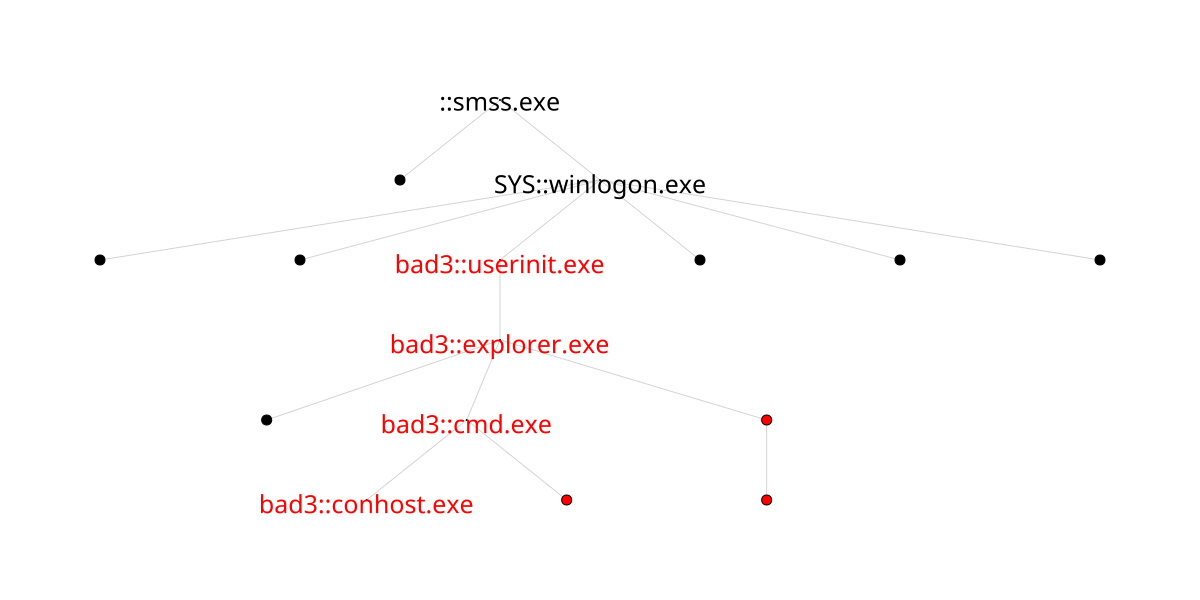

In [64]:
## pick one of the top hits and visualize common path
tree = 13059
root = 173
sg2 = get_ordered_subtree(Trees, tree, root)
sg2.vs['newlabel'] = [re.sub(r'user\d+::','user::',x) for x in sg2.vs['label']]
paths, score = gwm.basic_matcher(sg1, sg2, phi_name='newlabel', w=split_match) ## node feature == process name

## plot reference tree
path = [int(x[0]) for x in paths]
sg1.vs['vertex_size'] = 10
sg1.vs['vertex_label_size'] = 1
for i in path:
    sg1.vs[i]['vertex_size'] = 1
    sg1.vs[i]['vertex_label_size'] = 25
ig.plot(sg1, bbox=(1200,600), layout=sg1['ly'], margin=100, 
        vertex_size=sg1.vs['vertex_size'], 
        vertex_label=sg1.vs['label'], 
        vertex_label_size=sg1.vs['vertex_label_size'], 
        edge_color='lightgrey', edge_arrow_size=0)

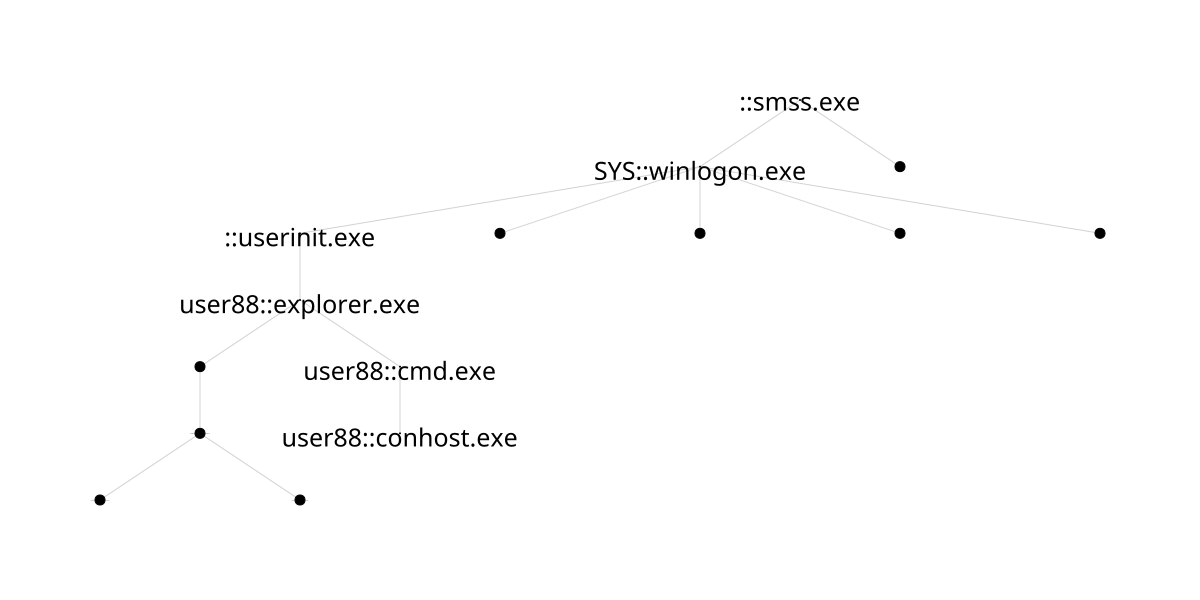

In [65]:
## plot top scoring tree
path = [int(x[1]) for x in paths]
sg2.vs['vertex_size'] = 10
sg2.vs['vertex_label_size'] = 1
for i in path:
    sg2.vs[i]['vertex_size'] = 1
    sg2.vs[i]['vertex_label_size'] = 25
ig.plot(sg2, "algo1_4.png", 
        bbox=(1200,600), layout=sg2['ly'], margin=100, 
        vertex_size=sg2.vs['vertex_size'], 
        vertex_label=sg2.vs['label'], 
        vertex_label_size=sg2.vs['vertex_label_size'], 
        edge_color='lightgrey', edge_arrow_size=0)